In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
pd.set_option('display.max_columns', 200)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use('fivethirtyeight')
import matplotlib_inline
from pathlib import Path
# get higher quality plots
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
import seaborn as sns
import datetime

In [2]:
%load_ext autoreload
%autoreload 1
%aimport src.utils.processes

# Questions
## Metadata
- `Date`: Is it a holiday? Do holidays have a greater attendance?
- `DayofWeek`: Is there greater attendance on weekends? Any particular day?
- `DayNight`: Do night games have greater attendance? Is there a best time? Could traffic be affecting this?
- `VistingTeamScore` and `HomeTeamScore`: Would average margin of victory/loss affect attendance?
- `VisitingTeamGameNumber`: Is early in the season, middle, or end have greater attendance?
- `HomeTeamGameNumber`: Is early in the season, middle, or end have greater attendance? Before or after all-star break?
- `NumberofOuts` and `LengthofGame`: How does length of game (min) and length of game in outs affect attendance? Do shorter games have longer attendance?
- `Park ID` does average temperature/climate of park affect attendance?

## Derived Features
- `Visiting team ranking` (find feature) effect on attendance?
- `Home team ranking` (find feature) effect on attendance?
- `VisitingTeam_StartingPitcher_Name` is all-star?
- `HomeTeam_StartingPitcher_Name` is all-star?
- How does number of all-stars affect attendance?
- How does average age of starting lineup affect attendance?
    - Try using `HomeTeam_Player_#_Name` and `VisitingTeam_Player_#_Name`

## Game Stats
- Visiting team offensive statistics?
- Visiting team pitching statistics?
- Visiting team defensive statistics?
- Home team offensive statistics?
- Home team pitching statistics?
- Home team defensive statistics?

In [3]:
DATA_PATH = Path('../../data')

In [4]:
df = pd.read_parquet(DATA_PATH.joinpath('processed', 'game_logs_standings.parquet'))

In [5]:
df.shape

(54482, 186)

In [6]:
arena_capacity = {
    "Angel Stadium of Anaheim": 45050,
    "Rangers Ballpark in Arlington": 49115,
    "Globe Life Field in Arlington": 40738,
    "Turner Field": 49586,
    "Suntrust Park": 41149,
    "Oriole Park at Camden Yards": 45971,
    "Fenway Park": 37755,
    "Sahlen Field": 16806,
    "Wrigley Field": 41915,
    "Guaranteed Rate Field;U.S. Cellular Field": 40615,
    "Cinergy Field": 40545,
    "Great American Ballpark": 42319,
    "Progressive Field": 35041,
    "Coors Field": 50144,
    "Comerica Park": 41083,
    "TD Ballpark": 8500,
    "Field of Dreams": 8000,
    "Fort Bragg Field": 12000,
    "Minute Maid Park": 41168,
    "Kauffman Stadium": 37903,
    "The Ballpark at Disney's Wide World": 11500,
    "London Stadium": 60000,
    "Dodger Stadium": 56000,
    "Sun Life Stadium": 34742,
    "Marlins Park": 36742,
    "County Stadium": 53000,
    "Miller Park": 41828,
    "Hubert H. Humphrey Metrodome": 55333,
    "Target Field": 38949,
    "Estadio Monterrey": 27702,
    "Stade Olympique": 45623,
    "Yankee Stadium I": 56703,
    "Shea Stadium": 57000,
    "Citi Field": 41922,
    "Yankee Stadium II": 54251,
    "Oakland-Alameda County Coliseum": 46796,
    "TD Ameritrade Park": 24000,
    "Veterans Stadium": 62546,
    "Citizens Bank Park": 42793,
    "Chase Field": 48519,
    "Three Rivers Stadium": 59000,
    "PNC Park": 38362,
    "Qualcomm Stadium": 70561,
    "PETCO Park": 40845,
    "Safeco Field": 47943,
    "AT&T Park": 41915,
    "Estadio Hiram Bithorn": 19100,
    "Busch Stadium II": 50553,
    "Busch Stadium III": 43975,
    "Tropicana Field": 31042,
    "Sydney Cricket Ground": 48000,
    "Tokyo Dome": 55000,
    "Rogers Centre": 53340,
    "Robert F. Kennedy Stadium": 56638,
    "Nationals Park": 41168,
    "BB&T Ballpark at Bowman Field": 2300,
}

In [7]:
stadiums = pd.read_csv(DATA_PATH.joinpath('raw', 'stadiums.csv'))
stadiums = stadiums.loc[stadiums.PARKID.isin(df['BallParkID']), 
                        ['PARKID', 'NAME']].reset_index(drop=True)

In [8]:
stadiums['capacity'] = stadiums.NAME.map(arena_capacity)

In [9]:
stadiums.to_csv(DATA_PATH.joinpath('processed', 'stadiums.csv'))

In [10]:
# drops too many cols
# df['GB'] = pd.to_numeric(df['GB'], errors='coerce')
df.drop('GB', axis='columns', inplace=True)

In [11]:
df.columns.tolist()

['Gm#',
 'Year',
 'Date',
 'Unnamed: 3',
 'Tm',
 'Unnamed: 5',
 'Opp',
 'W/L',
 'R',
 'RA',
 'Inn',
 'W-L',
 'HomeTeam_Rank',
 'Win',
 'Loss',
 'Save',
 'Time',
 'D/N',
 'Attendance_TRUTH_x',
 'HomeTeam_cLI',
 'Streak',
 'Orig. Scheduled',
 'At',
 'VisitingTeam',
 'HomeTeam',
 'HomeTeam_W',
 'HomeTeam_L',
 'HomeTeam_Streak_count',
 'VisitingTeam_W',
 'VisitingTeam_L',
 'VisitingTeam_Rank',
 'VisitingTeam_cLI',
 'VisitingTeam_Streak_count',
 'Attendance_TRUTH_y',
 'NumberofGames',
 'DayofWeek',
 'VisitingTeamLeague',
 'VisitingTeamGameNumber',
 'HomeTeamLeague',
 'HomeTeamGameNumber',
 'VistingTeamScore',
 'HomeTeamScore',
 'NumberofOuts',
 'DayNight',
 'BallParkID',
 'Attendance',
 'LengthofGame',
 'VisitingTeam_LineScore',
 'HomeTeam_LineScore',
 'VisitingTeamOffense_AtBats',
 'VisitingTeamOffense_Hits',
 'VisitingTeamOffense_Doubles',
 'VisitingTeamOffense_Triples',
 'VisitingTeamOffense_Homeruns',
 'VisitingTeamOffense_RBIs',
 'VisitingTeamOffense_SacrificeHits',
 'VisitingTeamOffen

In [12]:
for col in df.columns:
    print(col, df[col].dtype)

Gm# int64
Year object
Date datetime64[ns]
Unnamed: 3 object
Tm object
Unnamed: 5 object
Opp object
W/L object
R int64
RA int64
Inn float64
W-L object
HomeTeam_Rank int64
Win object
Loss object
Save object
Time object
D/N object
Attendance_TRUTH_x float64
HomeTeam_cLI float64
Streak object
Orig. Scheduled object
At object
VisitingTeam object
HomeTeam object
HomeTeam_W int64
HomeTeam_L int64
HomeTeam_Streak_count int64
VisitingTeam_W int64
VisitingTeam_L int64
VisitingTeam_Rank int64
VisitingTeam_cLI float64
VisitingTeam_Streak_count int64
Attendance_TRUTH_y float64
NumberofGames int64
DayofWeek object
VisitingTeamLeague object
VisitingTeamGameNumber int64
HomeTeamLeague object
HomeTeamGameNumber int64
VistingTeamScore int64
HomeTeamScore int64
NumberofOuts int64
DayNight object
BallParkID object
Attendance float64
LengthofGame int64
VisitingTeam_LineScore object
HomeTeam_LineScore object
VisitingTeamOffense_AtBats int64
VisitingTeamOffense_Hits int64
VisitingTeamOffense_Doubles int64
Vi

# Converting Categorical Variables to Meaningful Quantitative

## Feature Engineering

In [13]:
# collect wins and losses for home team
df['W'] = df['W-L'].apply(lambda s: s.split('-')[0]).astype('int')
df['L'] = df['W-L'].apply(lambda s: s.split('-')[1]).astype('int')

In [14]:
# count wins in a row or losses in a row as negative
df['Streak'].unique()

array(['---', '+', '++', '-', '--', '----', '-------', '--------', '+++',
       '-----', '++++', '+++++', '++++++', '------', '+++++++',
       '++++++++', '+++++++++', '---------', '----------', '++++++++++',
       '+++++++++++', '-----------', '------------', '----------------',
       '-----------------', '------------------', '-------------------',
       '-------------', '--------------', '---------------',
       '++++++++++++', '++++++++++++++', '++++++++++++++++',
       '+++++++++++++++++', '++++++++++++++++++', '+++++++++++++++++++',
       '++++++++++++++++++++', '+++++++++++++++++++++',
       '++++++++++++++++++++++', '+++++++++++++', '+++++++++++++++'],
      dtype=object)

In [15]:
# convert streak to quantitative
df['Streak_count'] = df['Streak'].apply(lambda s: s.count('+') if s.startswith('+')
                                        else -1 * s.count('-'))

In [16]:
df[['DayNight', 'StadiumID', 'VisitingTeamLeague', 'HomeTeamLeague']] = src.utils.processes.to_numerical(df, ['DayNight', 'BallParkID',
                                                                                           'VisitingTeamLeague',
                                                                                           'HomeTeamLeague'])

In [17]:
df[['HomeTeam_StartingPitcher_ID', 'VisitingTeam_StartingPitcher_ID']] = src.utils.processes.to_numerical(df,
                                                                                                          ['HomeTeam_StartingPitcher_ID', 'VisitingTeam_StartingPitcher_ID'])


In [18]:
stadiums.head()

PARKID                           NAME  capacity
0  ANA01       Angel Stadium of Anaheim     45050
1  ARL02  Rangers Ballpark in Arlington     49115
2  ARL03  Globe Life Field in Arlington     40738
3  ATL02                   Turner Field     49586
4  ATL03                  Suntrust Park     41149

In [19]:
mapping = dict(zip(stadiums.PARKID, stadiums.capacity))
df['Stadium_Capacity'] = df['BallParkID'].map(mapping)

In [20]:
df = pd.concat([df, pd.get_dummies(df['DayofWeek'])], axis=1)

In [21]:
df['Year'] = df['Date'].apply(lambda d: d.year)
df['Month'] = df['Date'].apply(lambda d: d.month)
df['Day'] = df['Date'].apply(lambda d: d.day)

In [22]:
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M').apply(lambda d: d.hour)
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M').apply(lambda d: d.minute)

In [23]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2000-01-01', end='2022-12-31').to_pydatetime()

In [24]:
df['is_holiday'] = df['Date'].apply(lambda d: d in holidays).astype('int')

In [25]:
df['is_holiday'].value_counts()

0    53507
1      975
Name: is_holiday, dtype: int64

In [26]:
df = df.loc[df.Tm == df.HomeTeam]
df = df[df.columns.unique()]

In [28]:
group = df.groupby(['Year', 'HomeTeam', 'VisitingTeam'])['Attendance_TRUTH_y'].mean()
for idx, row in df.iterrows():
    # year is at least 2001
    if row.Year > df.Year.min():
        try:
            # find average attendance of all previous year matchups of home team with visting team
            df.loc[idx, 'avg_attendance_1_yr_ago'] = group[row.Year - 1][row.HomeTeam][row.VisitingTeam]
        except KeyError:
            # find average attendance of all previous year games of home team
            df.loc[idx, 'avg_attendance_1_yr_ago'] = df.loc[df.Year == df.Year - 1, 'Attendance_TRUTH_y'].mean()
    else:
        # year is 2000 and we don't have any information
        df.loc[idx, 'avg_attendance_1_yr_ago'] = np.nan

In [33]:
# filter by threshold of not null values
thresh = 0.8
df = df[[col for col in df.columns if df[col].notnull().sum() > df[col].shape[0] * thresh]]
# ensure appropriate data types
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
# drop null rows
df.dropna(axis=0, inplace=True)
df.drop(['Unnamed: 3', 'Attendance_TRUTH_x', 'Attendance'], axis=1, inplace=True)

/var/folders/n2/pk82njb95y52mychzbkmz5zm0000gn/T/ipykernel_28746/3972769037.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
/var/folders/n2/pk82njb95y52mychzbkmz5zm0000gn/T/ipykernel_28746/3972769037.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, inplace=True)
/var/folders/n2/pk82njb95y52mychzbkmz5zm0000gn/T/ipykernel_28746/3972769037.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

In [34]:
df.shape

(43665, 195)

In [36]:
df.head()

Gm#  Year       Date   Tm  Opp   W/L  R  RA  W-L  HomeTeam_Rank      Win  \
74    7  2001 2001-04-10  SDN  SFN     L  6  11  3-4              3    Ortiz   
75    8  2001 2001-04-11  SDN  SFN     L  1   2  3-5              3    Fultz   
76    9  2001 2001-04-12  SDN  SFN     W  8   3  4-5              3    Eaton   
77   10  2001 2001-04-13  SDN  LAN  W-wo  5   4  5-5              3  Hoffman   
78   11  2001 2001-04-14  SDN  LAN  W-wo  5   4  6-5              2  Hoffman   

         Loss  Time D/N  HomeTeam_cLI Streak VisitingTeam HomeTeam  \
74     Jarvis  2:49   D          1.11      -          SFN      SDN   
75    Hoffman  2:52   N          1.09     --          SFN      SDN   
76  Hernández  2:54   D          1.02      +          SFN      SDN   
77     Herges  3:32   N          1.05     ++          LAN      SDN   
78      Olson  2:44   N          1.10    +++          LAN      SDN   

    HomeTeam_W  HomeTeam_L  HomeTeam_Streak_count  VisitingTeam_W  \
74           3           4                     -1               5   
75           3           5                     -2               6   
76           4           5                      1               6   
77           5           5                      2               6   
78           6           5                      3               6   

    VisitingTeam_L  VisitingTeam_Rank  VisitingTeam_cLI  \
74               2                  1              1.20   
75               2                  1              1.27   
76               3                  1              1.29   
77               5                  2              1.19   
78               6                  3              1.12   

    VisitingTeam_Streak_count  Attendance_TRUTH_y  NumberofGames DayofWeek  \
74                          2             61277.0              0       Tue   
75                          3             50149.0              0       Wed   
76                         -1             25730.0              0       Thu   
77                         -1             29883.0              0       Fri   
78                         -2             50750.0              0       Sat   

    VisitingTeamLeague  VisitingTeamGameNumber  HomeTeamLeague  \
74                 1.0                       7             1.0   
75                 1.0                       8             1.0   
76                 1.0                       9             1.0   
77                 1.0                      11             1.0   
78                 1.0                      12             1.0   

    HomeTeamGameNumber  VistingTeamScore  HomeTeamScore  NumberofOuts  \
74                   7                11              6            54   
75                   8                 2              1            54   
76                   9                 3              8            51   
77                  10                 4              5            58   
78                  11                 4              5            53   

    DayNight BallParkID  LengthofGame VisitingTeam_LineScore  \
74       0.0      SAN01           169              404000120   
75       1.0      SAN01           172              000000101   
76       0.0      SAN01           174              000102000   
77       1.0      SAN01           212             0020010100   
78       1.0      SAN01           164              200001010   

   HomeTeam_LineScore  VisitingTeamOffense_AtBats  VisitingTeamOffense_Hits  \
74          000000240                          38                        11   
75          000001000                          30                         5   
76          00030230x                          33                         8   
77         0001200011                          35                         5   
78          200002001                          33                         7   

    VisitingTeamOffense_Doubles  VisitingTeamOffense_Triples  \
74                            1                            0   
75                            3        

In [37]:
DATA_PATH = Path('../../data')
df.to_parquet(DATA_PATH.joinpath('processed', 'game_logs_standings_v2.parquet'))

In [38]:
df_features = df.copy()

avg_attendance_1_yr_ago          0.683566
HomeTeam_Rank                    0.329635
Stadium_Capacity                 0.317291
HomeTeam_cLI                     0.246525
HomeTeam_W                       0.168512
W                                0.168512
HomeTeamLeague                   0.135653
VisitingTeamLeague               0.131276
HomeTeam_Player9_Position        0.109673
VisitingTeam_Player9_Position    0.106168
DayNight                         0.106105
HomeTeam_Streak_count            0.081542
Streak_count                     0.081542
VisitingTeam_W                   0.074710
VisitingTeam_cLI                 0.072384
LengthofGame                     0.067976
VisitingTeamGameNumber           0.063460
HomeTeamGameNumber               0.063349
Gm#                              0.063299
Month                            0.059064
Name: Attendance_TRUTH_y, dtype: float64

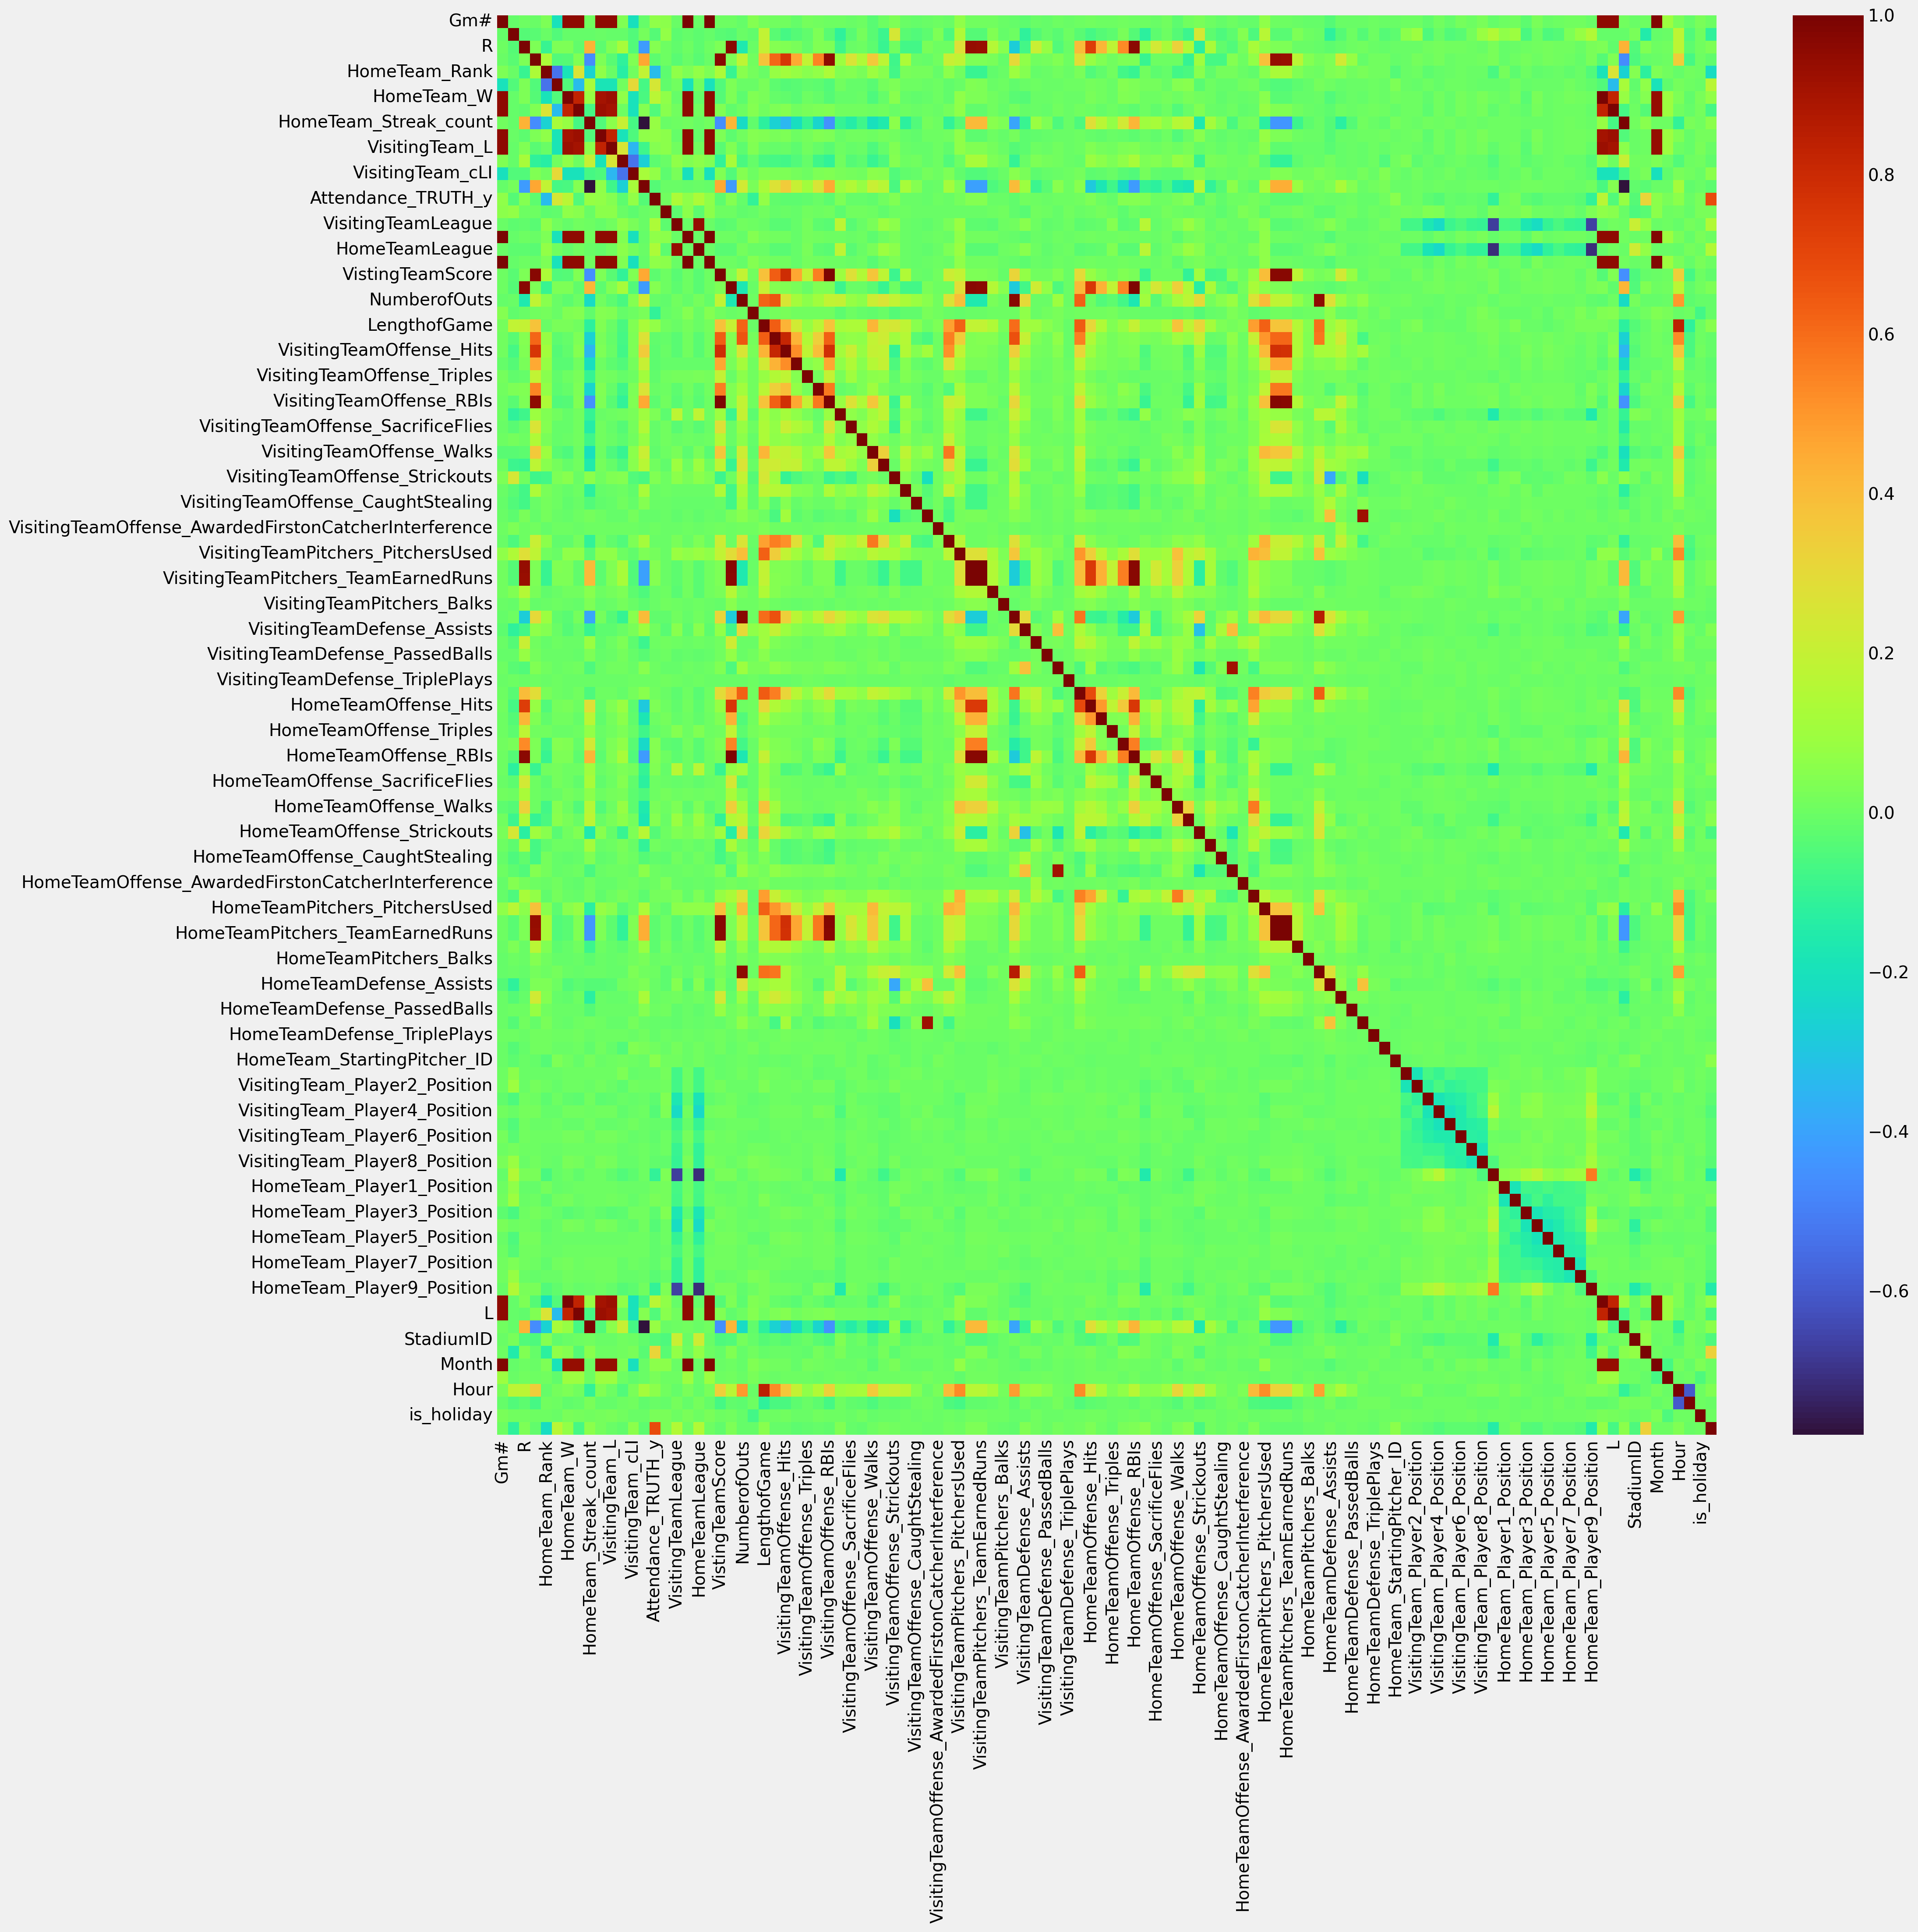

In [39]:
# pearson correlations
corr = df_features.select_dtypes(['int', 'float']).corr(method='pearson')
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sns.heatmap(corr, cmap='turbo', ax=ax)
# filter by top 20 strongest pearson correlations with attendance excluding attendance with itself
display(corr.loc[corr.index != 'Attendance_TRUTH_y', 'Attendance_TRUTH_y'].abs().sort_values(ascending=False).iloc[:20])

In [40]:
p_correlated_features = corr.loc[corr.index != 'Attendance_TRUTH_y', 'Attendance_TRUTH_y'] \
                          .abs().sort_values(ascending=False).iloc[:20].index.to_numpy()
p_correlated_features

array(['avg_attendance_1_yr_ago', 'HomeTeam_Rank', 'Stadium_Capacity',
       'HomeTeam_cLI', 'HomeTeam_W', 'W', 'HomeTeamLeague',
       'VisitingTeamLeague', 'HomeTeam_Player9_Position',
       'VisitingTeam_Player9_Position', 'DayNight',
       'HomeTeam_Streak_count', 'Streak_count', 'VisitingTeam_W',
       'VisitingTeam_cLI', 'LengthofGame', 'VisitingTeamGameNumber',
       'HomeTeamGameNumber', 'Gm#', 'Month'], dtype=object)

<Axes: >

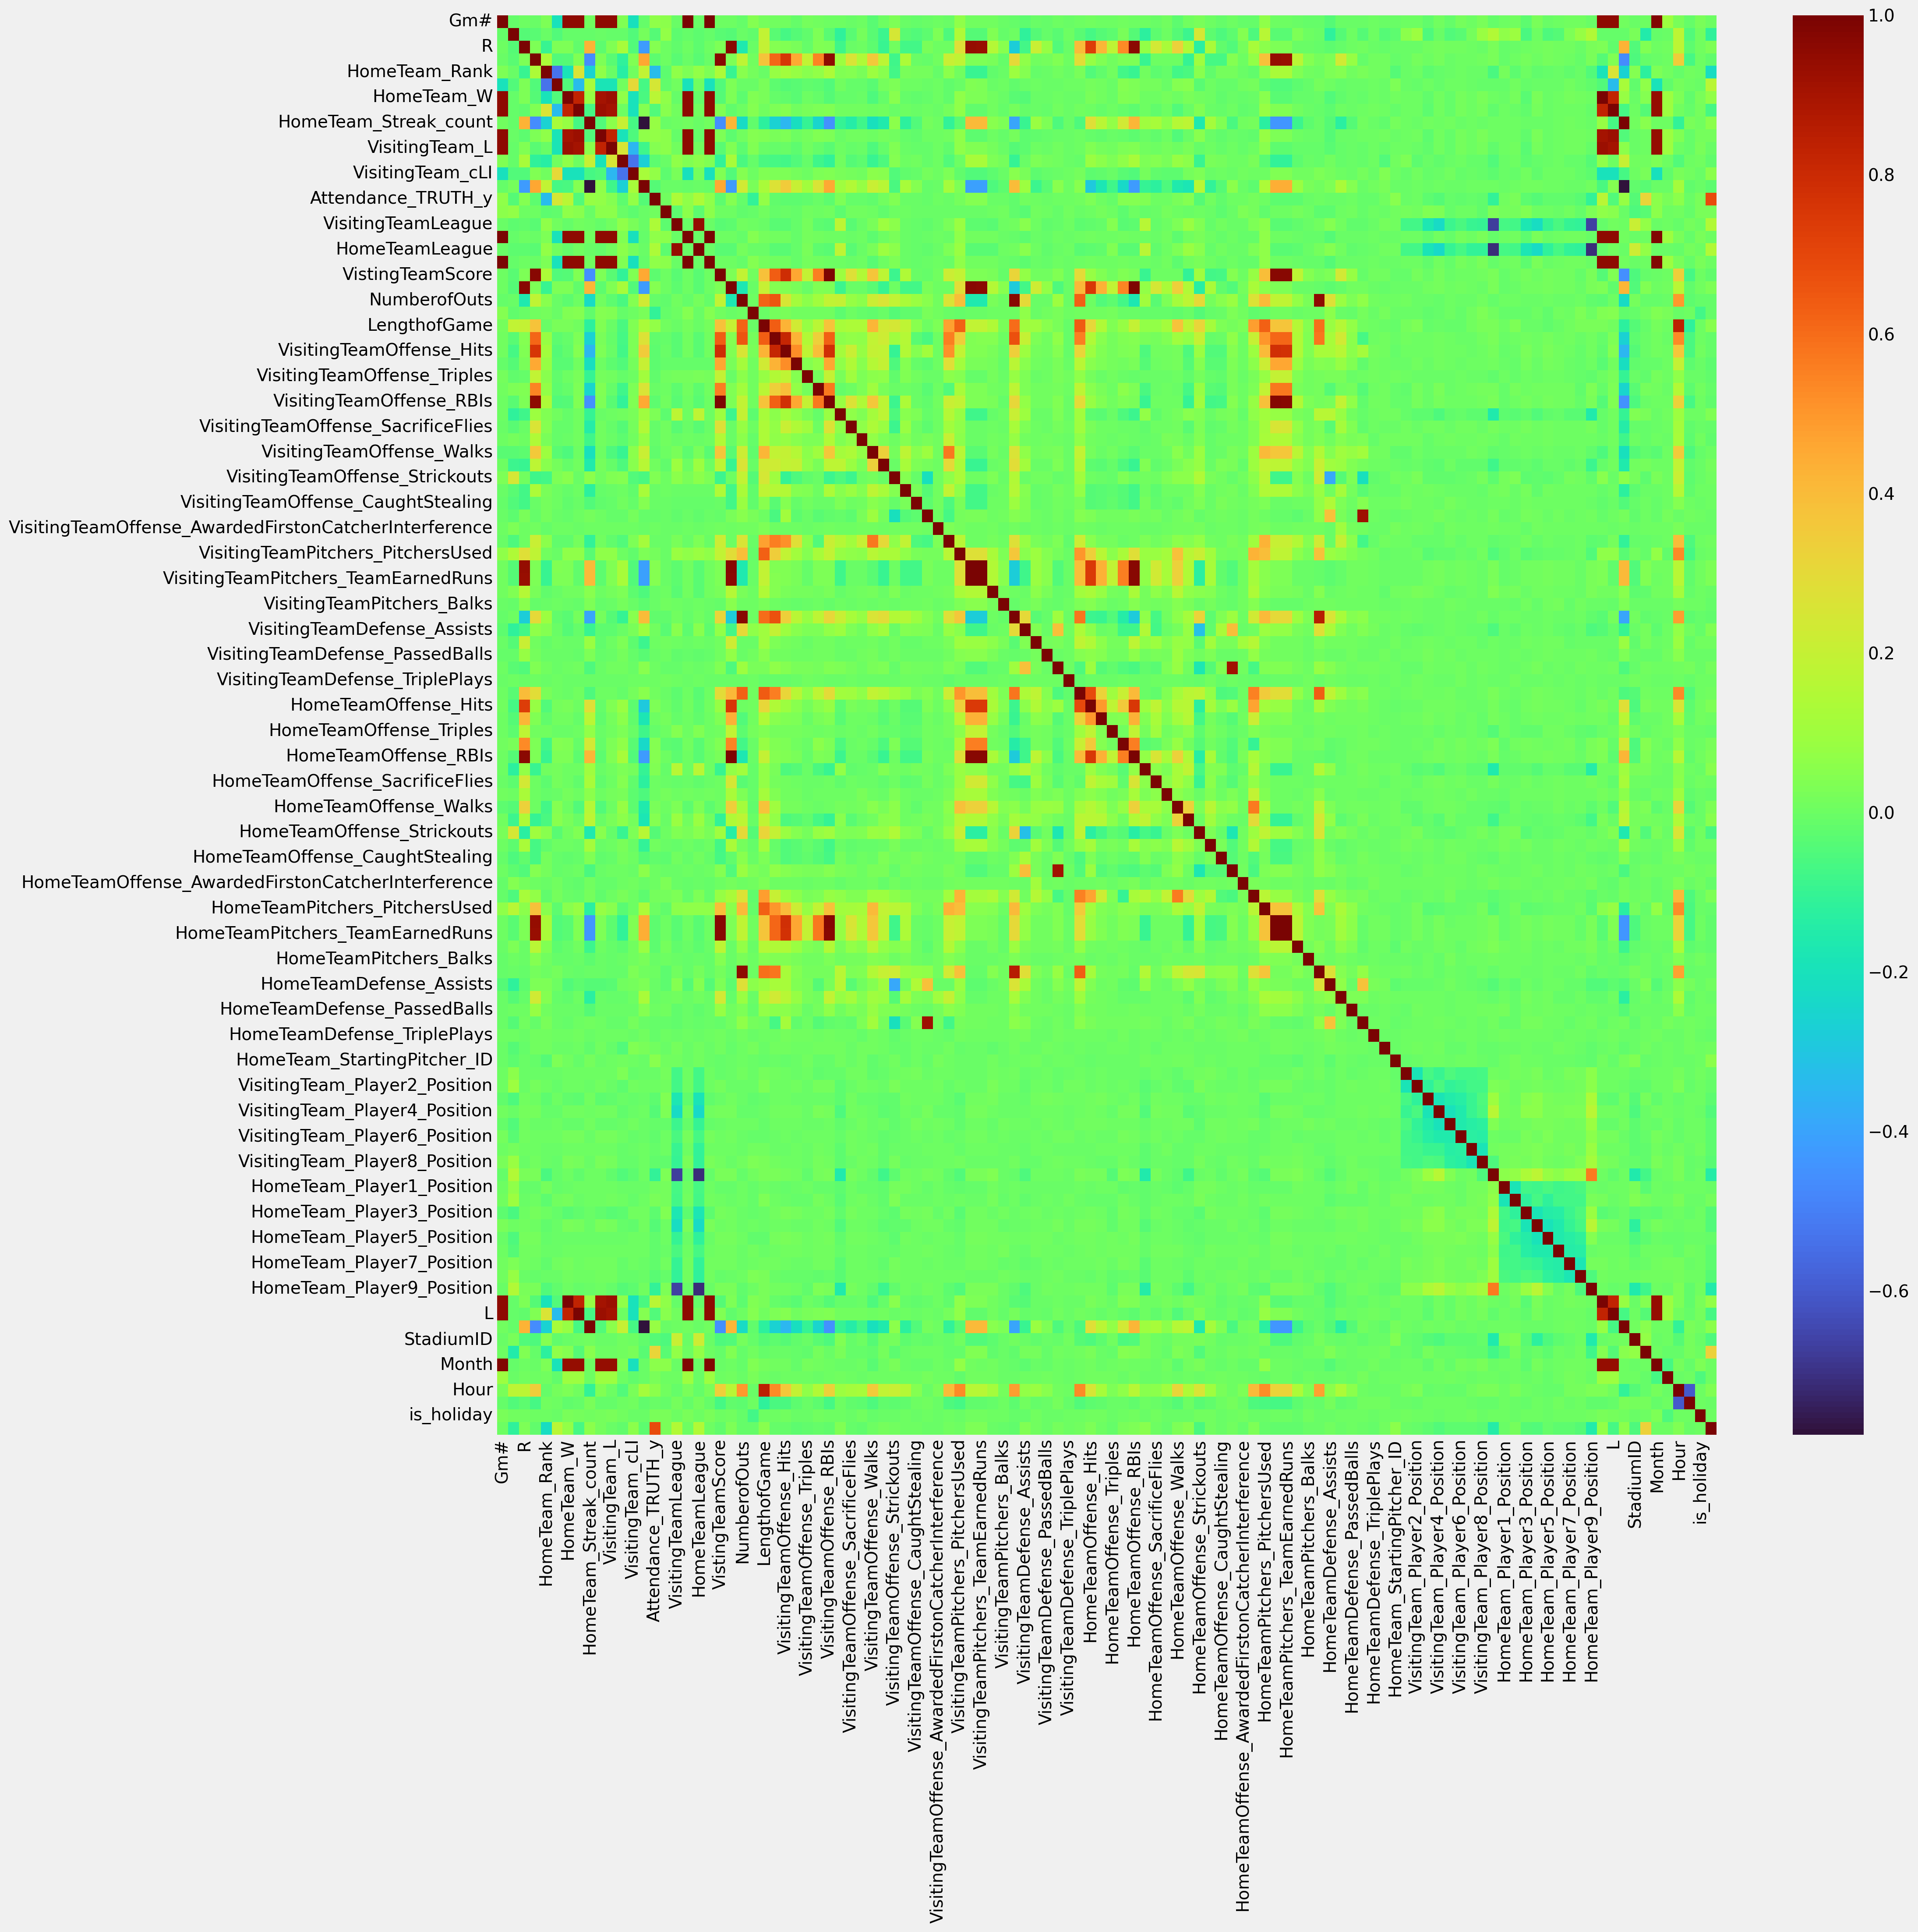

In [41]:
corr = df_features.select_dtypes(['int', 'float']).corr(method='pearson')
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sns.heatmap(corr, cmap='turbo', ax=ax)

avg_attendance_1_yr_ago          0.677039
HomeTeam_Rank                    0.331819
Stadium_Capacity                 0.307545
HomeTeam_cLI                     0.265937
HomeTeam_W                       0.159772
W                                0.159772
HomeTeamLeague                   0.141171
VisitingTeamLeague               0.136603
HomeTeam_Player9_Position        0.128973
VisitingTeam_Player9_Position    0.128260
DayNight                         0.104951
VisitingTeam_W                   0.073490
Streak_count                     0.070294
HomeTeam_Streak_count            0.070294
LengthofGame                     0.067602
VisitingTeam_cLI                 0.060371
HomeTeamGameNumber               0.057880
VisitingTeamGameNumber           0.057876
Gm#                              0.057833
Hour                             0.055876
Name: Attendance_TRUTH_y, dtype: float64

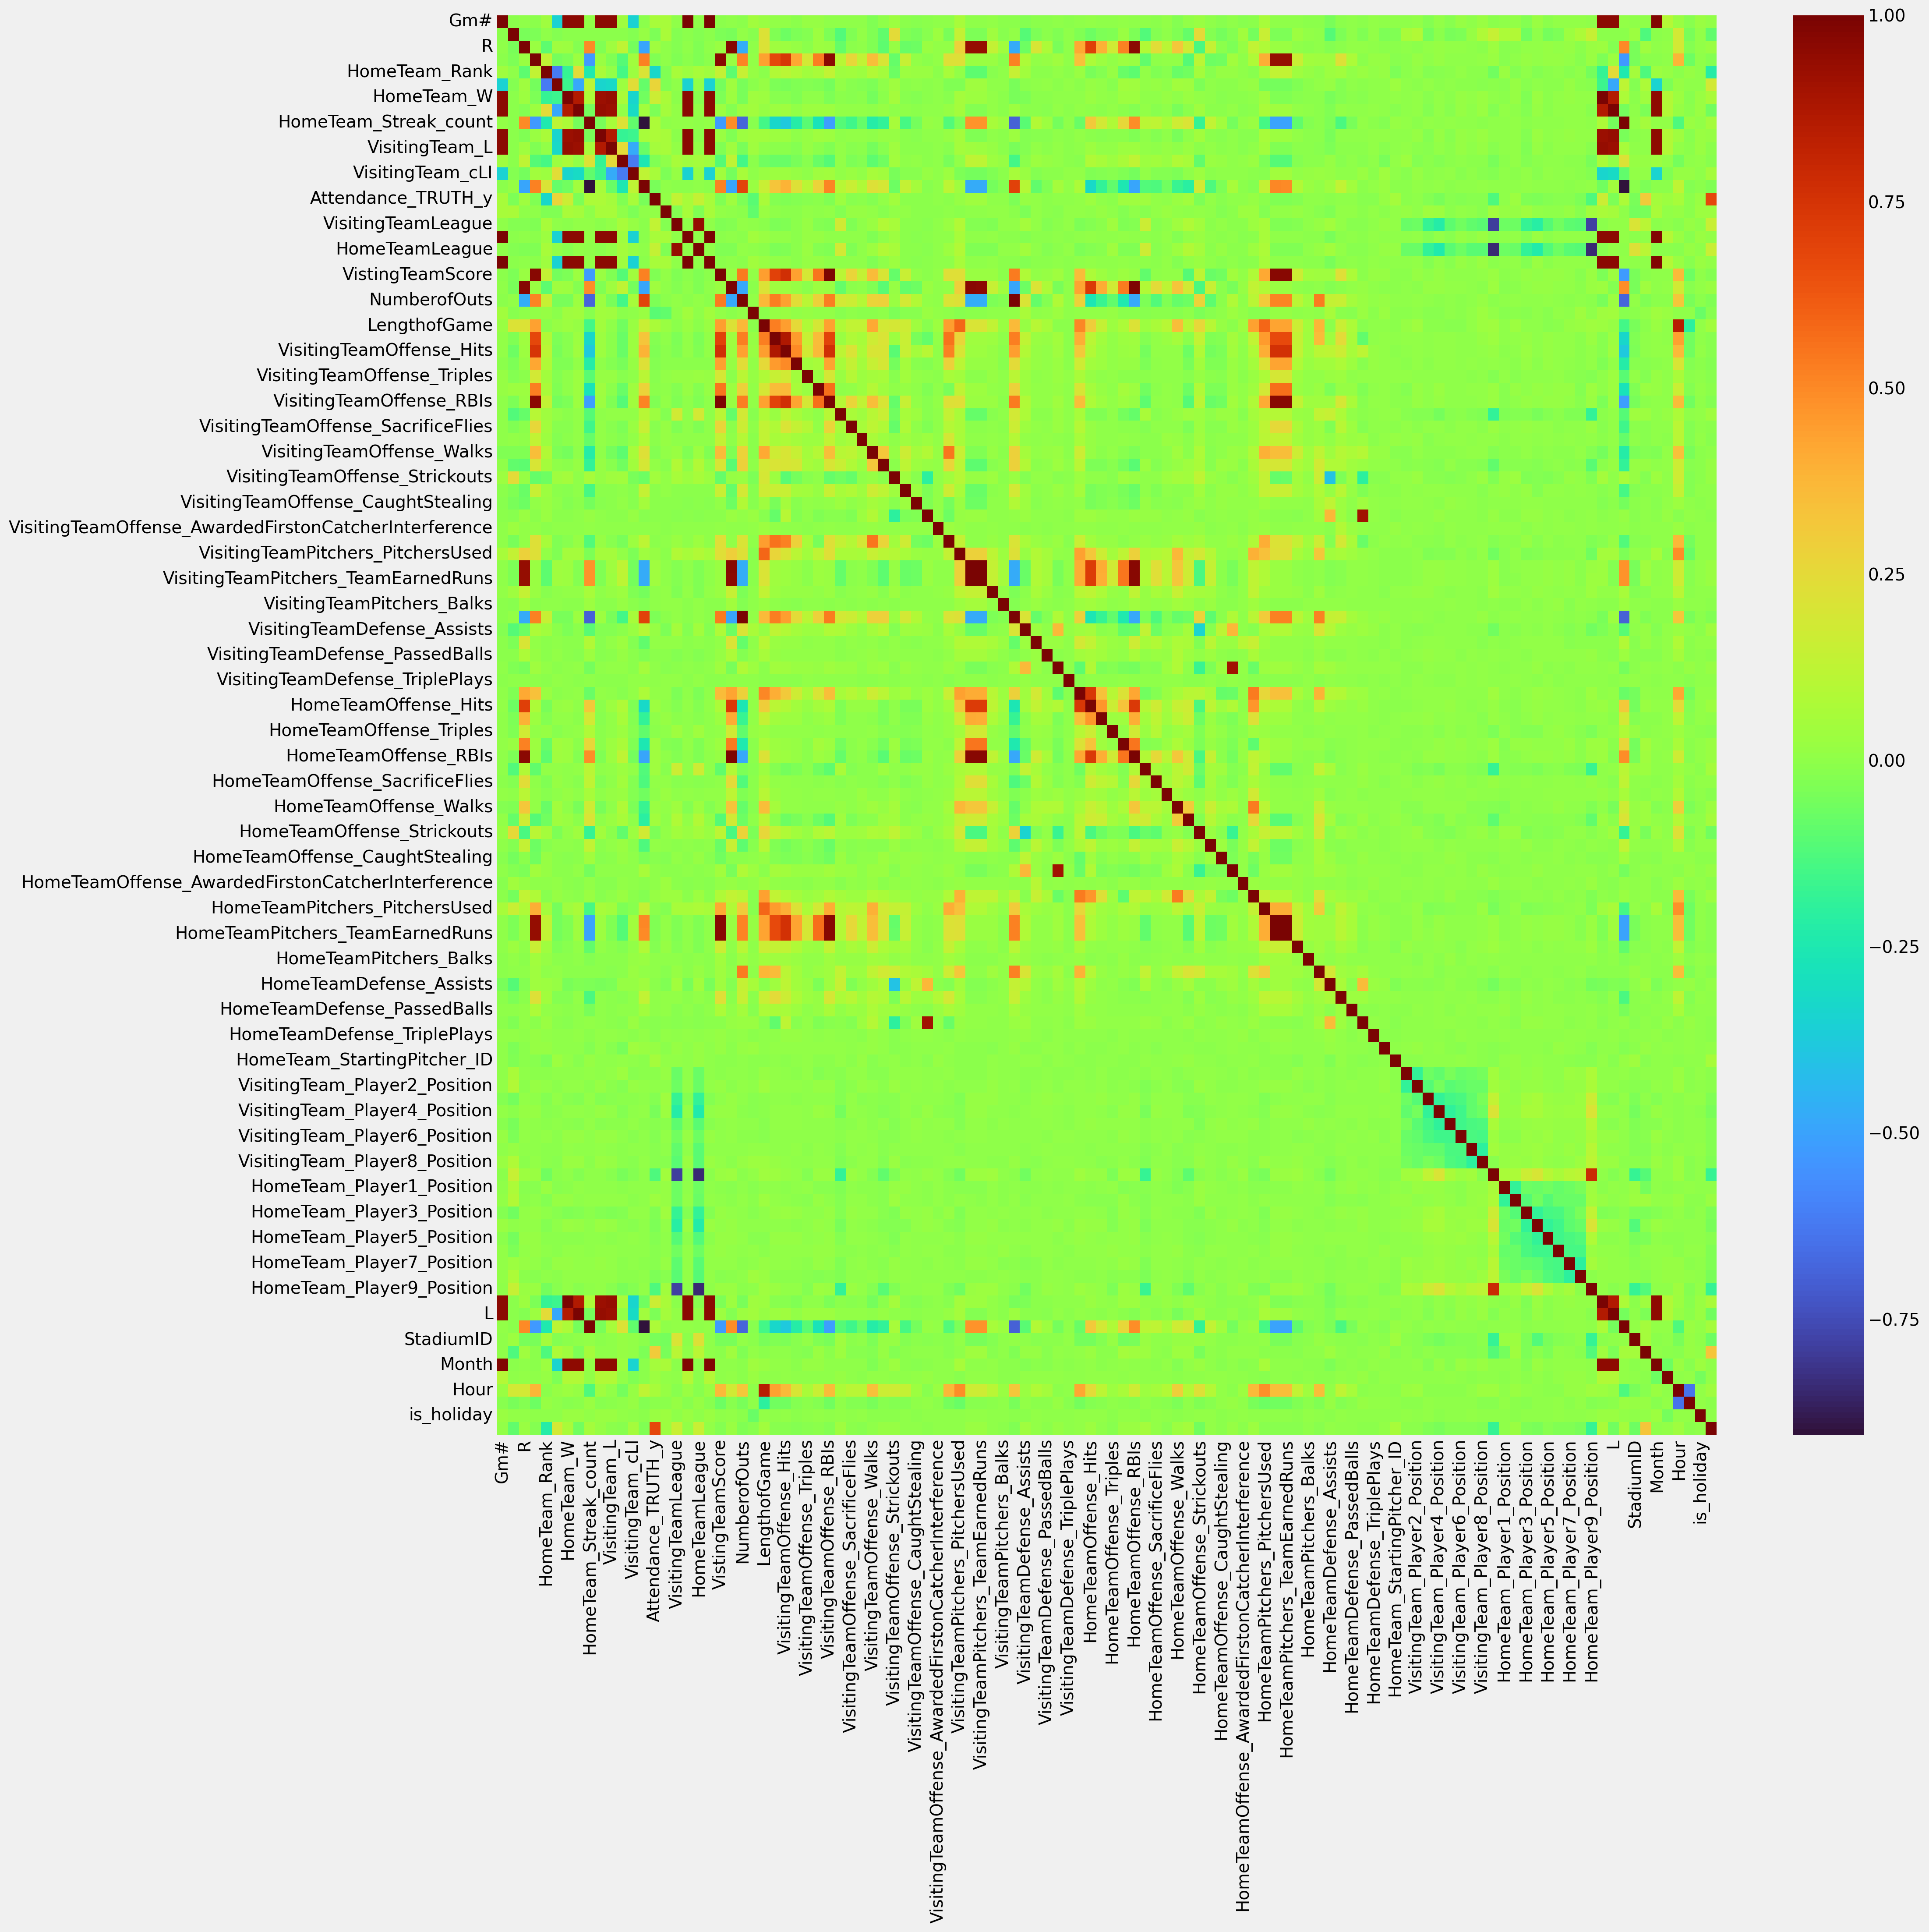

In [42]:
# spearman correlations - monotonic relationships
corr = df_features.select_dtypes(['int', 'float']).corr(method='spearman')
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sns.heatmap(corr, cmap='turbo', ax=ax)
# filter by top 20 strongest pearson correlations with attendance excluding attendance with itself
display(corr.loc[corr.index != 'Attendance_TRUTH_y', 'Attendance_TRUTH_y'].abs().sort_values(ascending=False).iloc[:20])

In [43]:
s_correlated_features = corr.loc[corr.index != 'Attendance_TRUTH_y', 'Attendance_TRUTH_y'] \
                          .abs().sort_values(ascending=False).iloc[:20].index.to_numpy()
s_correlated_features

array(['avg_attendance_1_yr_ago', 'HomeTeam_Rank', 'Stadium_Capacity',
       'HomeTeam_cLI', 'HomeTeam_W', 'W', 'HomeTeamLeague',
       'VisitingTeamLeague', 'HomeTeam_Player9_Position',
       'VisitingTeam_Player9_Position', 'DayNight', 'VisitingTeam_W',
       'Streak_count', 'HomeTeam_Streak_count', 'LengthofGame',
       'VisitingTeam_cLI', 'HomeTeamGameNumber', 'VisitingTeamGameNumber',
       'Gm#', 'Hour'], dtype=object)

In [44]:
# find intersection of pearson and spearman correlations for linear regression features
p = set(p_correlated_features)
s = set(s_correlated_features)
features = list(p.intersection(s))
features = np.array(features)

In [45]:
features

array(['W', 'HomeTeam_Rank', 'HomeTeam_Streak_count', 'HomeTeam_cLI',
       'LengthofGame', 'VisitingTeamLeague', 'Streak_count', 'HomeTeam_W',
       'HomeTeam_Player9_Position', 'VisitingTeam_Player9_Position',
       'Stadium_Capacity', 'DayNight', 'VisitingTeam_cLI',
       'avg_attendance_1_yr_ago', 'Gm#', 'VisitingTeamGameNumber',
       'VisitingTeam_W', 'HomeTeamGameNumber', 'HomeTeamLeague'],
      dtype='<U29')

In [46]:
p_correlated_features

array(['avg_attendance_1_yr_ago', 'HomeTeam_Rank', 'Stadium_Capacity',
       'HomeTeam_cLI', 'HomeTeam_W', 'W', 'HomeTeamLeague',
       'VisitingTeamLeague', 'HomeTeam_Player9_Position',
       'VisitingTeam_Player9_Position', 'DayNight',
       'HomeTeam_Streak_count', 'Streak_count', 'VisitingTeam_W',
       'VisitingTeam_cLI', 'LengthofGame', 'VisitingTeamGameNumber',
       'HomeTeamGameNumber', 'Gm#', 'Month'], dtype=object)